# 2024 Mock Exam - Association Rules

Consider the file provided with the assignment and perform the tasks described below.
The solution must be produced as a Python Notebook, assuming that the dataset is in the same folder as the notebook. The notebook must include
appropriate comments and must operate as follows:

1. Upload the file Online-Retail-France.xlsx. It is a MS Excel file, you
can read it with the Pandas function read_excel, show the size and a
small portion of its content (1pt)

2. It is a transactional database where the role of transaction identifier
is played by the column InvoiceNo and the items are in the column
Description. Print the number of unique Description values (1pt)

3. Some descriptions represent the same item but have different leading or
trailing spaces, therefore they must be made uniform with the Pandas
function str.strip() Print the number of unique Description values
after this cleaning (1pt)

4. Some rows may not have an InvoiceNo and must be removed, because
they cannot be used. Check if there are such that rows and in case
remove them. Inspect the effect of this cleaning (1pt)

5. Some InvoiceNo start with a C. They are "credit transactions" and
must be removed. Inspect the effect of this cleaning (1pt)

6. Several transactions include the item POSTAGE, which represents the
mailing expenses. In this analysis we are not interested in it, therefore the rows with POSTAGE will be removed. Inspect the effect of this
cleaning (1pt)

7. After the cleanup, we need to consolidate the items into one transaction per row with products one–hot–encoded. To do so, group by
InvoiceNo and Description computing a sum on Quantity, use the
Pandas unstack function to move the items from rows to columns, reset
the index, fill the missing with zero, store the result in a new dataframe
basket and inspect it (2pt)

8. There are a lot of zeros in the data but we also need to convert to True
the positive values and to False the non–positive values. Inspect the
result of this transformation and verify the correctness (1pt)

9. find the maximum value of min_support such that the number of rules
generated from the frequent itemsets with lift not less than 1 is at least 20. Show the value obtained for min_support and show the rules.
Hint: use a loop with an initial value min_support=1 and decrease it in
steps -0.01
Hint: In apriori set the parameter use_colnames=True (2pt)

10. Generate the rules with association_rules using metric=lift and
min_threshold=1 (4pt)

11. In order to scatter–plot some information about the rules, it is better
to sort them according to some metrics.
We will sort on descending lift and confidence, then do a scatter plot
of them (1pt)

Quality of the code 
(4pt)
• Include appropriate comments with reference to the numbered requirements

• Useless cells, pieces of code and non-required output will be penalised

• Remove the code you use for testing and inspecting the variables during
the development

• Naming style of variables must be uniform and in English

• Bad indentation and messy code will be penalised

• Non generalised solution, such as three sequential statements with the
same kind of operation instead of a loop, will be penalised


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

url = 'Online-Retail-France.xlsx'
random_state = 42

C:\Users\foxdo\AppData\Local\Temp\ipykernel_23080\2325685226.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. Upload the file Online-Retail-France.xlsx. It is a MS Excel file, you can read it with the Pandas function read_excel, show the size and a small portion of its content (1pt)


In [2]:
df = pd.read_excel(url)
print('DataFrame size is {}'.format(df.size))
df

DataFrame size is 59899


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0
...,...,...,...,...,...,...,...
8552,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0
8553,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0
8554,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0
8555,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0


##  2. It is a transactional database where the role of transaction identifier is played by the column InvoiceNo and the items are in the column Description. Print the number of unique Description values (1pt)



In [3]:
print('The DataFrame contains {} unique Descriptions'.format(len(np.unique(df['Description']))))

The DataFrame contains 1565 unique Descriptions


## 3. Some descriptions represent the same item but have different leading or trailing spaces, therefore they must be made uniform with the Pandas function str.strip() Print the number of unique Description values after this cleaning (1pt)



In [4]:
df['Description'] = [desc.strip() for desc in df['Description']]
print('The DataFrame contains {} unique (stripped) Descriptions'.format(len(np.unique(df['Description']))))

The DataFrame contains 1564 unique (stripped) Descriptions


## 4. Some rows may not have an InvoiceNo and must be removed, because they cannot be used. Check if there are such that rows and in case remove them. Inspect the effect of this cleaning (1pt)



In [5]:
print('There are {} rows with null InvoiceNo'.format(len(df[df['InvoiceNo'].isnull()])))
df.dropna(subset=('InvoiceNo'))
print('Resulting DataFrame shape: {}'.format(df.shape))

There are 0 rows with null InvoiceNo
Resulting DataFrame shape: (8557, 7)


## 5. Some InvoiceNo start with a C. They are "credit transactions" and must be removed. Inspect the effect of this cleaning (1pt)



In [6]:
indexes_to_remove = []

for idx, row in df.iterrows():
    if(row.InvoiceNo.count('C') > 0):
        indexes_to_remove.append(idx)

print('Removing {} credit transactions..'.format(len(indexes_to_remove)))

df.drop(index=indexes_to_remove, axis=0, inplace=True)
print('Resulting DataFrame shape: {}'.format(df.shape))

Removing 149 credit transactions..
Resulting DataFrame shape: (8408, 7)


## 6. Several transactions include the item POSTAGE, which represents the mailing expenses. In this analysis we are not interested in it, therefore the rows with POSTAGE will be removed. Inspect the effect of this cleaning (1pt)



In [7]:
indexes_to_remove = []

for idx, row in df.iterrows():
    if(row.Description.count('POSTAGE') > 0):
        indexes_to_remove.append(idx)
        
print('Removing {} items including POSTAGE in Description field..'.format(len(indexes_to_remove)))
df.drop(index=indexes_to_remove, axis=0, inplace=True)
print('Resulting DataFrame shape: {}'.format(df.shape))

Removing 300 items including POSTAGE in Description field..
Resulting DataFrame shape: (8108, 7)


## 7. After the cleanup, we need to consolidate the items into one transaction per row with products one–hot–encoded. To do so, group by InvoiceNo and Description computing a sum on Quantity, use the Pandas unstack function to move the items from rows to columns, reset the index, fill the missing with zero, store the result in a new dataframe basket and inspect it (2pt)



In [8]:
# Group by 'InvoiceNo' and 'Description', summing the 'Quantity'
grouped_df = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().reset_index()

# Use unstack to pivot the 'Description' values to columns
basket = grouped_df.pivot(index='InvoiceNo', columns='Description', values='Quantity').fillna(0)

# Reset the index
basket.reset_index(inplace=True)

# Inspect the resulting dataframe
basket.head()

Description,InvoiceNo,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
0,536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 8. There are a lot of zeros in the data but we also need to convert to True the positive values and to False the non–positive values. Inspect the result of this transformation and verify the correctness (1pt)



In [9]:
# Convert positive values to True and non-positive values to False
basket_boolean = basket.iloc[:, 1:].applymap(lambda x: x > 0)

# Inspect the resulting dataframe
basket_boolean.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 9. find the maximum value of min_support such that the number of rules generated from the frequent itemsets with lift not less than 1 is at least 20. Show the value obtained for min_support and show the rules. 

Hint: use a loop with an initial value min_support=1 and decrease it in steps -0.01 

Hint: In apriori set the parameter use_colnames=True (2pt)



In [10]:
from mlxtend.frequent_patterns import apriori, association_rules

min_rules = 20

support = 1

while True:
    print('Trying support: {:.2f}..'.format(support))
    frequent_itemset = apriori(basket_boolean, min_support=support, use_colnames=True)
    
    if(len(frequent_itemset) > 0):
        rules = association_rules(frequent_itemset, metric='lift')
        
        if(len(rules) > min_rules):
            print('Found maximum min_support: {:.2f}\tNumber of itemsets: {}\tNumber of found rules: {}'.format(support, len(frequent_itemset), len(rules)))
            break

    support-=0.01
    
    if (support <= 0):
        print('No itemset found! Breaking..')

Trying support: 1.00..
Trying support: 0.99..
Trying support: 0.98..
Trying support: 0.97..
Trying support: 0.96..
Trying support: 0.95..
Trying support: 0.94..
Trying support: 0.93..
Trying support: 0.92..
Trying support: 0.91..
Trying support: 0.90..
Trying support: 0.89..
Trying support: 0.88..
Trying support: 0.87..
Trying support: 0.86..
Trying support: 0.85..
Trying support: 0.84..
Trying support: 0.83..
Trying support: 0.82..
Trying support: 0.81..
Trying support: 0.80..
Trying support: 0.79..
Trying support: 0.78..
Trying support: 0.77..
Trying support: 0.76..
Trying support: 0.75..
Trying support: 0.74..
Trying support: 0.73..
Trying support: 0.72..
Trying support: 0.71..
Trying support: 0.70..
Trying support: 0.69..
Trying support: 0.68..
Trying support: 0.67..
Trying support: 0.66..
Trying support: 0.65..
Trying support: 0.64..
Trying support: 0.63..
Trying support: 0.62..
Trying support: 0.61..
Trying support: 0.60..
Trying support: 0.59..
Trying support: 0.58..
Trying supp

In [11]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.098191,0.103359,0.074935,0.763158,7.383553,0.064786,3.785817,0.958700
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.103359,0.098191,0.074935,0.725000,7.383553,0.064786,3.279305,0.964225
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,0.070716,4.909561,0.978926
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,0.070716,5.561154,0.976129
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.095607,0.103359,0.074935,0.783784,7.583108,0.065054,4.146964,0.959901
5,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.103359,0.095607,0.074935,0.725000,7.583108,0.065054,3.288701,0.968200
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.100775,0.126615,0.072351,0.717949,5.670330,0.059592,3.096547,0.915948
7,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.126615,0.100775,0.072351,0.571429,5.670330,0.059592,2.098191,0.943047
8,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.139535,0.170543,0.090439,0.648148,3.800505,0.066643,2.357405,0.856371
9,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.170543,0.139535,0.090439,0.530303,3.800505,0.066643,1.831958,0.888385


## 10. Generate the rules with association_rules using metric=lift and min_threshold=1 (4pt)



In [12]:
rules_1 = association_rules(frequent_itemset, metric='lift', min_threshold=1)
rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.098191,0.103359,0.074935,0.763158,7.383553,0.064786,3.785817,0.958700
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.103359,0.098191,0.074935,0.725000,7.383553,0.064786,3.279305,0.964225
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,0.070716,4.909561,0.978926
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,0.070716,5.561154,0.976129
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.095607,0.103359,0.074935,0.783784,7.583108,0.065054,4.146964,0.959901
5,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.103359,0.095607,0.074935,0.725000,7.583108,0.065054,3.288701,0.968200
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.100775,0.126615,0.072351,0.717949,5.670330,0.059592,3.096547,0.915948
7,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.126615,0.100775,0.072351,0.571429,5.670330,0.059592,2.098191,0.943047
8,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.139535,0.170543,0.090439,0.648148,3.800505,0.066643,2.357405,0.856371
9,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.170543,0.139535,0.090439,0.530303,3.800505,0.066643,1.831958,0.888385


## 11. In order to scatter–plot some information about the rules, it is better to sort them according to some metrics. We will sort on descending lift and confidence, then do a scatter plot of them (1pt)

In [13]:
sorted_rules = rules.sort_values(by=['lift', 'confidence'], ascending=False)
sorted_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,0.070716,5.561154,0.976129
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,0.070716,4.909561,0.978926
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.095607,0.103359,0.074935,0.783784,7.583108,0.065054,4.146964,0.959901
5,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.103359,0.095607,0.074935,0.725000,7.583108,0.065054,3.288701,0.968200
22,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.103359,0.129199,0.100775,0.975000,7.546500,0.087421,34.832041,0.967487
23,(SET/6 RED SPOTTY PAPER PLATES),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.129199,0.103359,0.100775,0.780000,7.546500,0.087421,4.075640,0.996196
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.098191,0.103359,0.074935,0.763158,7.383553,0.064786,3.785817,0.958700
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.103359,0.098191,0.074935,0.725000,7.383553,0.064786,3.279305,0.964225
20,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.103359,0.139535,0.100775,0.975000,6.987500,0.086353,34.418605,0.955664
25,(SET/6 RED SPOTTY PAPER CUPS),"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",0.139535,0.103359,0.100775,0.722222,6.987500,0.086353,3.227907,0.995842


<Axes: title={'center': 'Association Rules (dot proportional to lift)'}, xlabel='lift', ylabel='confidence'>

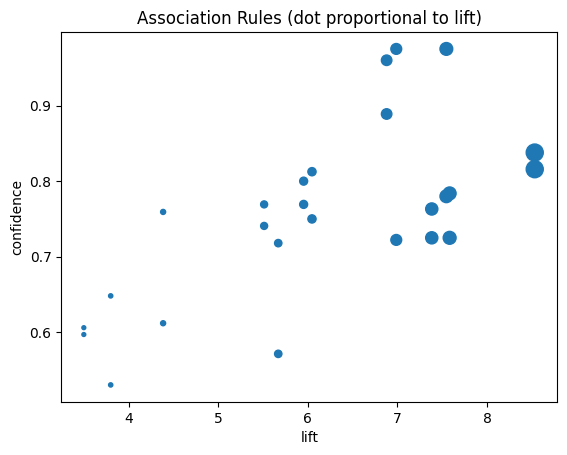

In [14]:
sorted_rules.plot.scatter(x='lift', y='confidence', s=[1.8**n for n in sorted_rules.lift], title='Association Rules (dot proportional to lift)')